In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 데이터 경로
base_dir = "/home/ec2-user/SageMaker/data/Binary_PNG"

# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# DataLoader 설정
dataloaders = {
    x: DataLoader(
        datasets.ImageFolder(root=os.path.join(base_dir, x), transform=data_transforms[x]),
        batch_size=32, shuffle=(x == 'train'), num_workers=4
    )
    for x in ['train', 'val', 'test']
}

# 데이터 크기 및 클래스 이름 확인
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
class_names = dataloaders['train'].dataset.classes

print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")


Classes: ['NG', 'OK']
Dataset sizes: {'train': 3977, 'val': 1136, 'test': 570}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pre-trained EfficientNet 모델 불러오기
model = models.efficientnet_b0(pretrained=True)  # EfficientNet B0 모델 사용

# Output Layer 수정 (OK/NG 이진 분류)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()  # 이진 분류
)
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.BCELoss()  # Binary CrossEntropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


In [5]:
# Early Stopping 기능 포함
def train_model_with_early_stopping(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_val_loss = float('inf')  # Validation Loss 최저값 초기화
    no_improvement_epochs = 0  # 개선되지 않은 에폭 수
    best_acc = 0.0  # Validation Accuracy 최고값 초기화

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float()  # Binary CrossEntropy에서는 float 타입 사용

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze(1)  # EfficientNet의 출력 크기 조정
                    preds = (outputs > 0.5).float()  # Threshold 0.5 적용
                    loss = criterion(outputs, labels)  # Loss 계산

                    if phase == 'train':
                        # Backward pass 및 최적화
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Loss 및 정확도 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Best 모델 저장 및 Early Stopping 확인
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    no_improvement_epochs = 0
                else:
                    no_improvement_epochs += 1

        # Early Stopping 조건
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # Best 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return model


In [6]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # BCELoss에 맞게 float으로 변환

            # Forward pass
            outputs = model(inputs).squeeze(1)  # EfficientNet 출력 크기 조정
            preds = (outputs > 0.5).float()  # 0.5를 기준으로 이진 분류

            # 결과 저장
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix 출력
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Classification Report 출력
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# 모델 학습
model = train_model_with_early_stopping(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=12, patience=5)

# 테스트 데이터 평가
print("\nTesting the model...")
evaluate_model(model, dataloaders['test'])

Epoch 1/12
--------------------
train Loss: 0.1060 Acc: 0.9693
val Loss: 0.0884 Acc: 0.9736
Epoch 2/12
--------------------
train Loss: 0.0434 Acc: 0.9852
val Loss: 0.0778 Acc: 0.9850
Epoch 3/12
--------------------
train Loss: 0.0277 Acc: 0.9915
val Loss: 0.0959 Acc: 0.9771
Epoch 4/12
--------------------
train Loss: 0.0352 Acc: 0.9889
val Loss: 0.0429 Acc: 0.9886
Epoch 5/12
--------------------
train Loss: 0.0182 Acc: 0.9942
val Loss: 0.0442 Acc: 0.9894
Epoch 6/12
--------------------
train Loss: 0.0209 Acc: 0.9925
val Loss: 0.1184 Acc: 0.9780
Epoch 7/12
--------------------
train Loss: 0.0296 Acc: 0.9922
val Loss: 0.0794 Acc: 0.9806
Epoch 8/12
--------------------
train Loss: 0.0171 Acc: 0.9937
val Loss: 0.0430 Acc: 0.9850
Epoch 9/12
--------------------
train Loss: 0.0091 Acc: 0.9957
val Loss: 0.0804 Acc: 0.9815
Early stopping triggered after 9 epochs.
Best Validation Loss: 0.0429

Testing the model...
Confusion Matrix:
[[126   5]
 [  1 438]]

Classification Report:
              p

In [8]:
import time
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    # 추론 시간 측정 시작
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 추론 시간 측정 종료
    end_time = time.time()
    inference_time = end_time - start_time

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # F1-score 점수 출력
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"\nWeighted F1-score: {f1:.4f}")

    # 추론 시간 출력
    print(f"\nInference Time (Total): {inference_time:.4f} seconds")
    print(f"Average Inference Time per Sample: {inference_time / len(y_true):.4f} seconds")

# 테스트 데이터 평가
evaluate_model(model, dataloaders['test'])

Confusion Matrix:
[[126   5]
 [  1 438]]

Classification Report:
              precision    recall  f1-score   support

          NG       0.99      0.96      0.98       131
          OK       0.99      1.00      0.99       439

    accuracy                           0.99       570
   macro avg       0.99      0.98      0.98       570
weighted avg       0.99      0.99      0.99       570


Weighted F1-score: 0.9894

Inference Time (Total): 13.0379 seconds
Average Inference Time per Sample: 0.0229 seconds


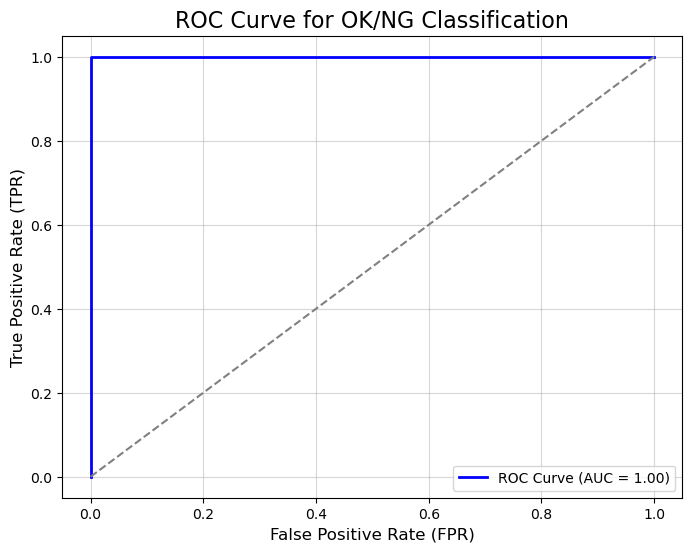

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# OK/NG 데이터 샘플링
ok_images = [
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/0.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1000.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1002.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1004.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1005.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1006.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1007.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1008.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1009.png"
    
]
ng_images = [
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1028.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1043.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1094.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1102.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1116.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1122.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1140.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1148.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1172.png"
    
    
]

# ROC 계산 함수
def compute_roc_for_images(model, image_paths, true_label):
    """
    Calculate ROC data for specific images.
    Args:
        model: Trained PyTorch model
        image_paths: List of image paths to evaluate
        true_label: Ground truth label (0 for OK, 1 for NG)
    Returns:
        y_true: List of true labels
        y_scores: List of predicted scores
    """
    y_true = []
    y_scores = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    for img_path in image_paths:
        # 이미지 불러오기
        img = datasets.folder.default_loader(img_path)  # PIL.Image로 로드
        img = transform(img).unsqueeze(0).to(device)  # 모델 입력 형태로 변환

        # 추론 수행
        with torch.no_grad():
            # 모델에서 출력값 추출
            output = model(img).squeeze(1)  # 모델 출력 (로짓)
            prob = torch.sigmoid(output).cpu().numpy()  # Sigmoid로 확률값 변환
            y_scores.append(prob[0])  # 첫 번째 출력 값 저장
            y_true.append(true_label)

    return y_true, y_scores

# OK/NG 클래스에 대한 ROC 데이터 생성
y_true_ok, y_scores_ok = compute_roc_for_images(model, ok_images, true_label=1)  # OK 클래스
y_true_ng, y_scores_ng = compute_roc_for_images(model, ng_images, true_label=0)  # NG 클래스

# ROC 데이터 병합
y_true = y_true_ok + y_true_ng
y_scores = y_scores_ok + y_scores_ng

# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title("ROC Curve for OK/NG Classification", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()